# Exemple d'extraction de graphe

## Setup

***Load modules*** 
This will require amtrack repo in the right path I use environment variables but feel free to do something better.
Normally all the required packages are indicated, if some are missing, please add them.
If you also want to create a "freeze" or a poetry thing to have an easier installation of the environment please do so.


In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pandas as pd
from amftrack.util.sys import get_dates_datetime, get_dirname, temp_path, get_data_info, update_plate_info, \
get_current_folders, get_folders_by_plate_id, fiji_path, path_code, update_plate_info_local, get_current_folders_local
import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    sparse_to_doc,
)
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.functions.image_processing.experiment_class_surf import Experiment, Edge,Node, plot_raw_plus
from amftrack.pipeline.launching.run_super import run_parallel_transfer, find_state, directory_scratch, directory_project, directory_archive
import dropbox
from amftrack.util.dbx import upload, zip_file
from subprocess import call
from tqdm.autonotebook import tqdm
from time import time_ns
import subprocess
import matplotlib as mpl
from amftrack.util.sys import temp_path, storage_path

/home/ipausers/kahane/Wks/AMFtrack/amftrack/util/dbx.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


***choose the path of interest***
I mounted sun on my linux computer at AMOLF. Please feel free to do so on yours as well. I can send you the command. 
Otherwise, if you have the folders locally, just indicate the path.
Finally you can also simply ssh to my computer and run things from there.

In [2]:
directory = os.path.join(storage_path, "plate1050")

In [3]:
update_plate_info_local(directory)

In [4]:
folder_df = get_current_folders_local(directory)

In [5]:
len(folder_df)

8

***Choose the folder you're interested in***

In [6]:
folder_df

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/skeleton_masked_compressed.mat,/Analysis/skeleton_pruned_compressed.mat,/Analysis/transform.mat,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder
11,/media/kahane/AMFtopology02/storage/plate1050/...,1050,18,'Carrot','C2','001P100N100C','Y','-',20220509,25,...,False,False,False,False,False,False,False,False,"12.05.2022, 18:33:",20220512_1833_Plate18
12,/media/kahane/AMFtopology02/storage/plate1050/...,1050,18,'Carrot','C2','001P100N100C','Y','-',20220509,25,...,False,False,False,False,False,False,False,False,"12.05.2022, 20:36:",20220512_2036_Plate18
13,/media/kahane/AMFtopology02/storage/plate1050/...,1050,18,'Carrot','C2','001P100N100C','Y','-',20220509,25,...,False,False,False,False,False,False,False,False,"12.05.2022, 22:36:",20220512_2236_Plate18
14,/media/kahane/AMFtopology02/storage/plate1050/...,1050,18,'Carrot','C2','001P100N100C','Y','-',20220509,25,...,False,False,False,False,False,False,False,False,"13.05.2022, 00:36:",20220513_0036_Plate18
15,/media/kahane/AMFtopology02/storage/plate1050/...,1050,18,'Carrot','C2','001P100N100C','Y','-',20220509,25,...,False,False,False,False,False,False,False,False,"13.05.2022, 02:36:",20220513_0236_Plate18
16,/media/kahane/AMFtopology02/storage/plate1050/...,1050,18,'Carrot','C2','001P100N100C','Y','-',20220509,25,...,False,False,False,False,False,False,False,False,"13.05.2022, 04:36:",20220513_0436_Plate18
17,/media/kahane/AMFtopology02/storage/plate1050/...,1050,18,'Carrot','C2','001P100N100C','Y','-',20220509,25,...,False,False,False,False,False,False,False,False,"13.05.2022, 06:36:",20220513_0636_Plate18
18,/media/kahane/AMFtopology02/storage/plate1050/...,1050,18,'Carrot','C2','001P100N100C','Y','-',20220509,25,...,False,False,False,False,False,False,False,False,"13.05.2022, 08:39:",20220513_0839_Plate18


In [7]:
str(folder_df["total_path"].iloc[1])

'/media/kahane/AMFtopology02/storage/plate1050/20220512_2036_Plate18'

In [10]:
folders = folder_df.loc[folder_df['Plate']=="1050"]

In [11]:
folders

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/skeleton_masked_compressed.mat,/Analysis/skeleton_pruned_compressed.mat,/Analysis/transform.mat,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder
11,/media/kahane/AMFtopology02/storage/plate1050/...,1050,18,'Carrot','C2','001P100N100C','Y','-',20220509,25,...,False,False,False,False,False,False,False,False,"12.05.2022, 18:33:",20220512_1833_Plate18
12,/media/kahane/AMFtopology02/storage/plate1050/...,1050,18,'Carrot','C2','001P100N100C','Y','-',20220509,25,...,False,False,False,False,False,False,False,False,"12.05.2022, 20:36:",20220512_2036_Plate18
13,/media/kahane/AMFtopology02/storage/plate1050/...,1050,18,'Carrot','C2','001P100N100C','Y','-',20220509,25,...,False,False,False,False,False,False,False,False,"12.05.2022, 22:36:",20220512_2236_Plate18
14,/media/kahane/AMFtopology02/storage/plate1050/...,1050,18,'Carrot','C2','001P100N100C','Y','-',20220509,25,...,False,False,False,False,False,False,False,False,"13.05.2022, 00:36:",20220513_0036_Plate18
15,/media/kahane/AMFtopology02/storage/plate1050/...,1050,18,'Carrot','C2','001P100N100C','Y','-',20220509,25,...,False,False,False,False,False,False,False,False,"13.05.2022, 02:36:",20220513_0236_Plate18
16,/media/kahane/AMFtopology02/storage/plate1050/...,1050,18,'Carrot','C2','001P100N100C','Y','-',20220509,25,...,False,False,False,False,False,False,False,False,"13.05.2022, 04:36:",20220513_0436_Plate18
17,/media/kahane/AMFtopology02/storage/plate1050/...,1050,18,'Carrot','C2','001P100N100C','Y','-',20220509,25,...,False,False,False,False,False,False,False,False,"13.05.2022, 06:36:",20220513_0636_Plate18
18,/media/kahane/AMFtopology02/storage/plate1050/...,1050,18,'Carrot','C2','001P100N100C','Y','-',20220509,25,...,False,False,False,False,False,False,False,False,"13.05.2022, 08:39:",20220513_0839_Plate18


These are local adaptations of functions for running things on the supercomputer. So better to keep them in the notebook at this stage.

## Stiching function

***Stitch the folders you're interested in***

should take about 20mins

In [7]:
from amftrack.pipeline.launching.run import run_stitch, make_stitching_loop, run

In [ ]:
run_stitch(directory, folders)

stitched:   0%|          | 0/8 [00:00<?, ?it/s]

/home/ipausers/kahane/opt/fiji-linux64/Fiji.app/ImageJ-linux64 --mem=8000m --headless --ij2 --console -macro /data/felix/TEMP/stitching_loops/stitching_loop1653399011230904628.ijm


Java HotSpot(TM) 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
Java HotSpot(TM) 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release


***Compress the image and skeletonize***

should take 1h30-2h

In [12]:
args = [directory]
run_parallel("compress_image.py", args, folders)

NameError: name 'run_parallel' is not defined

In [8]:
folders['total_path'].iloc[0]

NameError: name 'folders' is not defined

In [15]:
time = "3:00:00"
low = 30
high = 80
extend = 30
args=[low, high, extend,directory]
run('extract_skel.py',args,folders)

folder_treated:   0%|          | 0/8 [00:00<?, ?it/s]

python3 /home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/extract_skel.py 30 80 30 /media/kahane/AMFtopology02/storage/plate1050 1653399404319163701 0
Directory  /media/kahane/AMFtopology02/storage/plate1050/20220512_1833_Plate18/Analysis  already exists


/home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)
Traceback (most recent call last):
  File "/home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/extract_skel.py", line 78, in <module>
    skel[
ValueError: operands could not be broadcast together with shapes (3000,4096) (3000,4000) (3000,4096) 


python3 /home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/extract_skel.py 30 80 30 /media/kahane/AMFtopology02/storage/plate1050 1653399404319163701 1
Directory  /media/kahane/AMFtopology02/storage/plate1050/20220512_2036_Plate18/Analysis  already exists


/home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)
Traceback (most recent call last):
  File "/home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/extract_skel.py", line 78, in <module>
    skel[
ValueError: operands could not be broadcast together with shapes (3000,4096) (3000,4000) (3000,4096) 


python3 /home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/extract_skel.py 30 80 30 /media/kahane/AMFtopology02/storage/plate1050 1653399404319163701 2


/home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)
Traceback (most recent call last):
  File "/home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/extract_skel.py", line 78, in <module>
    skel[
ValueError: operands could not be broadcast together with shapes (3000,4096) (3000,4000) (3000,4096) 


Directory  /media/kahane/AMFtopology02/storage/plate1050/20220512_2236_Plate18/Analysis  already exists
python3 /home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/extract_skel.py 30 80 30 /media/kahane/AMFtopology02/storage/plate1050 1653399404319163701 3


/home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)
Traceback (most recent call last):
  File "/home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/extract_skel.py", line 78, in <module>
    skel[
ValueError: operands could not be broadcast together with shapes (3000,4096) (3000,4000) (3000,4096) 


Directory  /media/kahane/AMFtopology02/storage/plate1050/20220513_0036_Plate18/Analysis  already exists
python3 /home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/extract_skel.py 30 80 30 /media/kahane/AMFtopology02/storage/plate1050 1653399404319163701 4
Directory  /media/kahane/AMFtopology02/storage/plate1050/20220513_0236_Plate18/Analysis  already exists


/home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)
Traceback (most recent call last):
  File "/home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/extract_skel.py", line 78, in <module>
    skel[
ValueError: operands could not be broadcast together with shapes (3000,4096) (3000,4000) (3000,4096) 


python3 /home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/extract_skel.py 30 80 30 /media/kahane/AMFtopology02/storage/plate1050 1653399404319163701 5
Directory  /media/kahane/AMFtopology02/storage/plate1050/20220513_0436_Plate18/Analysis  already exists


/home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)
Traceback (most recent call last):
  File "/home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/extract_skel.py", line 78, in <module>
    skel[
ValueError: operands could not be broadcast together with shapes (3000,4096) (3000,4000) (3000,4096) 


python3 /home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/extract_skel.py 30 80 30 /media/kahane/AMFtopology02/storage/plate1050 1653399404319163701 6
Directory  /media/kahane/AMFtopology02/storage/plate1050/20220513_0636_Plate18/Analysis  already exists


/home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)
Traceback (most recent call last):
  File "/home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/extract_skel.py", line 78, in <module>
    skel[
ValueError: operands could not be broadcast together with shapes (3000,4096) (3000,4000) (3000,4096) 


python3 /home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/extract_skel.py 30 80 30 /media/kahane/AMFtopology02/storage/plate1050 1653399404319163701 7


/home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)
Traceback (most recent call last):
  File "/home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/extract_skel.py", line 78, in <module>
    skel[
ValueError: operands could not be broadcast together with shapes (3000,4096) (3000,4000) (3000,4096) 


Directory  /media/kahane/AMFtopology02/storage/plate1050/20220513_0839_Plate18/Analysis  already exists


## Visualisation

***Visualise the skeletonization***

In [8]:
select = folders
folder_list = list(select["total_path"])
folder_list.sort()
skels = []
ims = []
kernel = np.ones((5, 5), np.uint8)
itera = 1
start = 0

finish = start + 2
for folder in folder_list[start:finish]:
    path_snap = folder
    skel_info = read_mat(path_snap + "/Analysis/skeleton_compressed.mat")
    skel = skel_info["skeleton"]
    skels.append(cv2.dilate(skel.astype(np.uint8), kernel, iterations=itera))
    im = read_mat(path_snap + "/Analysis/raw_image.mat")["raw"]
    ims.append(im)

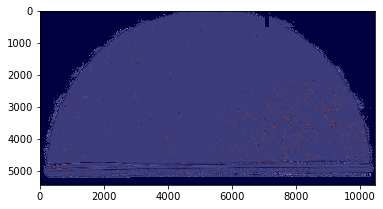

In [9]:
plt.close("all")
start = 0
finish = start + 1
for i in range(start, finish):
    plot_t_tp1([], [], None, None, skels[i], ims[i])

***These steps may be a bit long, but it also helps just keeping things consistent and use one single framework,*** you may bypass them by artificially renaming skeleton.mat into skeleton_realigned.mat which is necessary for the next step because you probably don't care about these two steps since you're doing only one image...

In [15]:
time = "2:00"
thresh = 50
args = [thresh, directory]
run_parallel("mask_skel.py", args, folders)

stitched:   0%|          | 0/1 [00:00<?, ?it/s]

python3 /home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/mask_skel.py 50 /data/felix/width1/full_plates/ 1649945483289864839 0
Directory  /data/felix/width1/full_plates/20220325_1423_Plate907/Analysis  already exists


In [9]:
time = "3:00:00"
threshold = 0.1
args = [threshold, directory]
run_parallel("prune_skel.py", args, folders)

stitched:   0%|          | 0/1 [00:00<?, ?it/s]

python3 /home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/prune_skel.py 0.1 /data/felix/width1/full_plates/ 1650013454133725000 0


In [10]:
plates = list(set(list(folders["Plate"].values)))
for plate in plates:
    time = "2:00:00"
    args = [directory]
    run_parallel("realign.py", args, folders)

stitched:   0%|          | 0/1 [00:00<?, ?it/s]

python3 /home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/realign.py /data/felix/width1/full_plates/ 1650033487466938247 0
saving 0 /data/felix/width1/full_plates/20220325_1423_Plate907


Now you're finally getting to the point where you generate the graph object

In [10]:
time = "2:00:00"
args = [directory]
run_parallel("extract_nx_graph.py", args, folders)

stitched:   0%|          | 0/1 [00:00<?, ?it/s]

python3 /home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/scripts/image_processing/extract_nx_graph.py /data/felix/width1/full_plates/ 1650033867641167166 0


# Brouillon